In [2]:
from __future__ import division
import collections
import sys
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# disable SettingWithCopyWarning warnings for imbalanced learn
pd.set_option('chained_assignment',None) 

%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import feature_selection as fsel
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
import sklearn.cross_validation as cv

from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, ShuffleSplit

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA, KernelPCA
import imblearn.over_sampling as imb

pd.set_option('display.max_columns', 100)# increase column display size                 
print pd.__version__, np.__version__     # sklearn: 0.18.1
print sys.version_info                   # note use of python 2.7, not python 3

0.19.1 1.11.2
sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)


In [3]:
col_is_binary = lambda xs: sorted(xs.dropna().unique()) == [0,1]
col_is_cat    = lambda xs: xs.dtype == np.dtype('O')

class CustomTrMixin(TransformerMixin, BaseEstimator):
    # inheriting from TransformerMixin gives fit_transform
    # inheriting from BaseEstimator gives grid_searchable parameters
    def __init__(self):
        # BaseEstimator: all args are all be named keyword args, no positional args or **kwargs
        pass

    def fit(self, X_in, y_in):
        # set state parameters
        return self

# Problem Formulation
- Student Retention: Keep Students in School and make sure they can graduate
- Determine which students in danger of dropping out such that resources could be adjusted
- Predictive model(s) for future students per graduation

## Load the data

In [4]:
df = pd.read_csv("data/graduates.csv")
n_obs, n_features = df.shape
target = 'graduated'
print "Num Observations:{0}, Num Features:{1}".format(n_obs, n_features)

Num Observations:1000, Num Features:33


## Explore the data
- there is a mix of categorical, binary, and continous data
- nominal feature to account for: 'professor'
- we have some missing values to make a decision regarding imputation
- we have plenty of de-identifed features (e.g. 'proprietary_xx')

In [5]:
def col_missing_values(df_in):
    missing_vals = {col: df_in[df_in[col].isnull()].shape[0] for col in df_in.columns }
    cols_missing_vals = dict( filter(lambda (k,v): v != 0, missing_vals.items() ) )
    return cols_missing_vals

cat_cols = [col for col in df.columns if col_is_cat(df[col])]
bin_cols = [col for col in df.columns if col_is_binary(df[col])]
missing_val_cols  = col_missing_values(df)

display(df.head())
# df.info()
# df.describe()
print "missing values via col: {}".format(missing_val_cols)
print "categorical cols: {}".format(cat_cols)
print "ordinal cols: {}".format(['classes_missed'])
print "binary cols:\n{}".format(bin_cols)

,admission_test,athlete,classes_missed,gpa,graduated,greek,hs_code,illness,professor,proprietary_01,proprietary_02,proprietary_03,proprietary_04,proprietary_05,proprietary_06,proprietary_07,proprietary_08,proprietary_09,proprietary_10,proprietary_11,proprietary_12,proprietary_13,proprietary_14,proprietary_15,proprietary_17,proprietary_18,proprietary_19,proprietary_20,proprietary_21,proprietary_22,proprietary_23,proprietary_24,proprietary_25
0,96.0,0,1,2.255,1,0.0,1434,0,prof_9,0.25,1.35,-0.86,0.77,1,1,1.32,0.53,0.64,0,-0.90,0.64,0.14,-0.68430,1,0,1,0.82,1,NaN,0,0.33,1,0.44
1,88.0,0,2,2.772,1,1.0,1122,0,prof_5,0.36,1.94,-0.86,0.77,0,1,-0.31,0.03,0.95,1,-1.18,0.67,-1.06,-3.93832,1,0,0,0.91,0,NaN,0,-0.35,0,0.83
2,90.0,0,0,3.740,1,0.0,1291,0,prof_6,0.77,-1.86,0.03,1.10,0,0,0.34,1.35,1.92,1,1.11,-0.30,-0.09,-1.33660,1,1,1,-0.88,1,NaN,0,-1.18,1,-0.82
3,122.0,0,2,3.206,1,0.0,1005,0,prof_5,0.39,0.29,-0.11,0.26,0,1,-0.70,-0.65,0.51,0,0.14,-2.44,0.21,-0.32674,0,1,1,-0.98,1,NaN,0,-0.74,0,-0.63
4,82.0,0,1,2.837,1,1.0,1403,0,prof_2,0.85,1.78,0.53,-0.46,1,1,-0.38,-0.26,-1.07,1,-0.66,1.85,0.67,0.90079,1,0,0,-0.41,0,NaN,1,-0.56,1,1.63


missing values via col: {'greek': 100, 'professor': 50, 'proprietary_21': 700, 'gpa': 20}
categorical cols: ['professor']
ordinal cols: ['classes_missed']
binary cols:
['athlete', 'graduated', 'greek', 'illness', 'proprietary_05', 'proprietary_06', 'proprietary_10', 'proprietary_15', 'proprietary_17', 'proprietary_18', 'proprietary_20', 'proprietary_22', 'proprietary_24']


### Feature Exploration
- none of the features are exhibiting a linear relationship w/target via pearsons correlation
- **class target highly skewed** to graduated (900 vs 100), not worth to explore graduate/non-graduated delta
- we have a few stragglers that are not produced well deserved gpa values > 2.0, with majority falling between 3.0-3.5
- is is possible that admission test scores > 100 mean something more.  Roughly symmetrical distribution
- those that graduated, do not miss class often (however as noted graduates target are skewed)
- the data classifications does not look to be linearly separable, unlikely that a basic linear model would be best

In [6]:
# select binary statistical count
# note the skew in the target class, very few that graduated; consider as rare class
cols = ['graduated', 'athlete', 'greek', 'illness']
df[cols].apply(lambda x: x.value_counts()/x.shape[0]).T

,0,1
graduated,0.100,0.900
athlete,0.978,0.022
greek,0.674,0.226
illness,0.988,0.012


In [7]:
# statistics 
display( df.groupby('graduated')[['admission_test', 'gpa']].mean() )
display( df.groupby(['graduated', 'professor'])[['admission_test', 'gpa']].count().T )
display( df.groupby(['graduated', 'professor'])[['admission_test', 'gpa']].mean().T  )

,admission_test,gpa
graduated,,
0,99.95,3.123465
1,98.14,3.087813


graduated           0                                                          \
professor      prof_0 prof_1 prof_2 prof_3 prof_4 prof_5 prof_6 prof_7 prof_8   
admission_test      1      1     13     12     18      9     15     12      9   
gpa                 1      1     13     11     18      9     15     12      9   

graduated                  1                                                \
professor      prof_9 prof_0 prof_1 prof_10 prof_11 prof_12 prof_13 prof_2   
admission_test      6      4     45      12       5       3       1    108   
gpa                 6      4     44      12       5       3       1    105   

graduated                                                        
professor      prof_3 prof_4 prof_5 prof_6 prof_7 prof_8 prof_9  
admission_test     96    163    127    129     77     60     24  
gpa                95    158    126    128     75     57     23

graduated             0                                              \
professor        prof_0   prof_1     prof_2      prof_3      prof_4   
admission_test  106.000  113.000  93.846154  101.916667  101.333333   
gpa               3.012    2.205   3.207154    2.881545    3.106722   

graduated                                                                  \
professor           prof_5      prof_6      prof_7      prof_8     prof_9   
admission_test  100.666667  100.066667  100.500000  103.666667  95.333333   
gpa               3.115778    3.183400    3.087083    3.193778   3.367333   

graduated              1                                                    \
professor         prof_0     prof_1   prof_10  prof_11    prof_12  prof_13   
admission_test  99.50000  97.888889  99.50000  92.2000  97.333333  107.000   
gpa              3.25975   3.079409   3.34925   2.9338   3.249000    3.046   

graduated                                                              \
professor          prof_2     prof_3     prof_4     prof_5     prof_6   
admission_test  97.120370  97.916667  97.926380  98.181102  98.108527   
gpa              3.095352   3.093863   3.093759   3.079476   3.028906   

graduated                                         
professor          prof_7      prof_8     prof_9  
admission_test  97.896104  103.100000  97.000000  
gpa              3.096213    3.217053   3.036174

In [8]:
# There doesn't seem to be any linear correlation with the target (graduated)
pd.DataFrame(df.corr()[target].sort_values(ascending=False)).drop(target, axis=0).T

,proprietary_22,proprietary_13,proprietary_14,proprietary_25,proprietary_11,proprietary_15,illness,proprietary_09,proprietary_01,athlete,proprietary_04,proprietary_06,proprietary_07,proprietary_23,proprietary_18,proprietary_10,proprietary_03,proprietary_24,greek,proprietary_20,hs_code,proprietary_05,proprietary_08,proprietary_12,classes_missed,proprietary_02,proprietary_21,proprietary_17,gpa,proprietary_19,admission_test
graduated,0.062739,0.054611,0.053806,0.039671,0.039339,0.037335,0.036736,0.03485,0.030833,0.02727,0.026432,0.021336,0.018776,0.013526,0.013333,0.00867,0.008472,0.008,0.007234,0.006,0.004746,0.003335,-0.004178,-0.004433,-0.005233,-0.006775,-0.013175,-0.014676,-0.0194,-0.034733,-0.051293


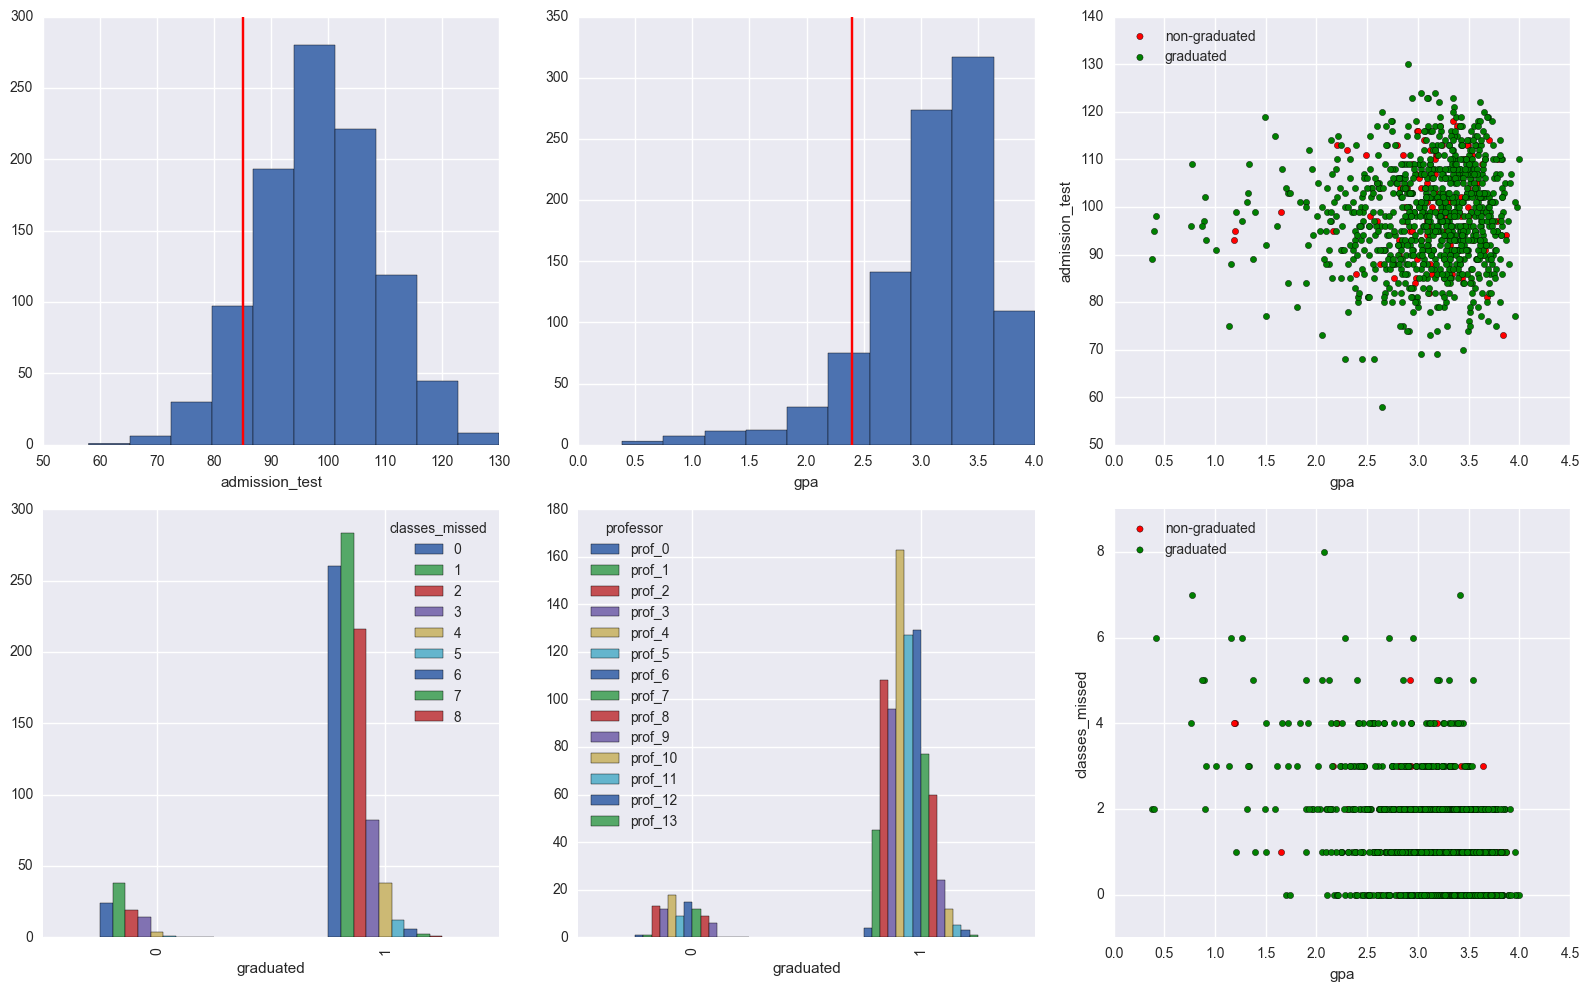

In [9]:
nrows, ncols = (2,3)
fig, (ax1,ax2) = plt.subplots(nrows, ncols, figsize=(16,10))
### Row 1
# Histograms
for col, axi in zip(['admission_test', 'gpa'], [ax1[0],ax1[1]]):
    df[col].hist(ax=axi)
    axi.set_xlabel(col)
    vline_lim  = np.percentile(df[col].dropna(), 10)
    axi.axvline(vline_lim, c='r')
# Is the data linearly separable via 2-axis (alternative: TSNE via all axis)
X = df.drop([target, 'professor'], axis=1)
y = df[target]
for cl, lab, marker, color in zip(xrange(2), ['non-graduated', 'graduated'], "ox", "rg"):
    ax1[2].scatter(X.loc[y == cl, 'gpa'], X.loc[y == cl, 'admission_test'], c=color, label=lab)
    ax1[2].set_xlabel('gpa')
    ax1[2].set_ylabel('admission_test')
ax1[2].legend(loc='upper left')

### Row 2
# Classes Missed via Target
pd.crosstab(df[target], df['classes_missed'], rownames=[target]).plot(kind='bar', ax=ax2[0])
# Professor via Target
prof_ids = sorted([int(s.split('_')[1]) for s in df.professor.dropna().unique()]) 
prof_order = ['prof_' + str(id_n) for id_n in prof_ids]
prof_grad  = pd.crosstab(df['graduated'], df['professor'], rownames=['graduated'])
prof_grad[prof_order].plot(kind='bar',ax=ax2[1])
# classes missed and gpa
for cl, lab, marker, color in zip(xrange(2), ['non-graduated', 'graduated'], "ox", "rg"):
    ax2[2].scatter(X.loc[y == cl, 'gpa'], X.loc[y == cl, 'classes_missed'], c=color, label=lab)
    ax2[2].set_xlabel('gpa')
    ax2[2].set_ylabel('classes_missed')
ax2[2].legend(loc='upper left')

plt.tight_layout()

## Preprocessing
- Outlier Detection
- Imputation
- Feature Engineering

### Outlier Detection
- For the most part, the 'proprietary_xx' values look rouhgly normally distributed
- Per the continuous *gpa* and *admission_test* columns, rather than dropping some of the possible outliers from the distribution, we will use indicator (dummy variables) to convey context.  As the goal is to provide information for students that require more attention or possibly in danger of retention. 

In [10]:
def outliers_zscore(data, dev=3):
    # does not perform well on small datasets, based on extreme values
    c_med = np.median(data)
    c_mu  = np.mean(data)
    c_std = np.std(data)
    z = (data - c_mu)/c_std
    return np.where(np.abs(z) > dev)

def outliers_iqr(data, lower_bound_only=True):
    q25, q75 = np.percentile(data, [25 ,75])
    iqr = q75-q25
    lower, upper = ( (q25 - (1.5*iqr)), (q75 + (1.5*iqr)) )
    if lower_bound_only: return (lower, np.where(data < lower) )
    else: return (lower, np.where( (data > upper) | (data < lower) ) )

def percentile_based_outlier(data, threshold=95, lower_bound_only=True):
    # cap-based method
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    if lower_bound_only: return(minval, np.where(data < minval) )
    else: return(minval, np.where( (data < minval) | (data > maxval) ) )
    
### Evaluate of outliers
for col in ['gpa', 'admission_test']:
    ys = df[col].dropna()
    print "col:{0}, mean:{1}, median:{2}, std:{3}".format( col, ys.mean(), ys.median(), ys.std() )
    print ys.iloc[outliers_zscore(ys)].shape
    lower, frame = outliers_iqr(ys)
    print lower, ys.iloc[frame].shape
    lower, frame = percentile_based_outlier(ys)
    print lower, ys.iloc[frame].shape

col:gpa, mean:3.09141428571, median:3.2095, std:0.554093382755
(21,)
1.9055 (37,)
1.60355 (25,)
col:admission_test, mean:98.321, median:98.0, std:10.5916071085
(1,)
68.5 (4,)
77.975 (25,)


In [11]:
class OutlierDetection(CustomTrMixin):
    def transform(self, X_in):
        # Based on the distribution, rather than remove these values, it makes more sense to treat as indicator
        # if admission_test < 80 (< q25)
        X_in['admtest_low'] = (X_in.admission_test < 80).astype(int)
        # if gpa < 2.0 (> q25)
        X_in['gpa_low'] = (X_in.gpa < 2.0).astype(int) 
        return X_in

### Imputation
- Cols Imputed: ['greek', 'professor', 'gpa']
- Cols Dropped (Due to too many missing values, based on 0.3 threshold): ['proprietary_21']

In [12]:
class ImputeDetection(CustomTrMixin):
    def __init__(self, threshold=0.3):
        self.threshold=0.3
    
    def fit(self, X_in, y_in):
        # determine which features have missing values, and the proportion of missing values
        # X_in.apply(lambda x: np.sum(pd.isnull(x))).sort_values(ascending=False)
        n_obs = X_in.shape[0]
        missing_prop = {col: X_in[X_in[col].isnull()].shape[0]/n_obs for col in X_in.columns }
        self.cols_missing_prop = dict( filter(lambda (k,v): v != 0, missing_prop.items() ) )
        return self
        
    def transform(self, X_in):
        # determine columns to impute
        cols_drop = [k for k,v in self.cols_missing_prop.iteritems() if v > self.threshold]
        cols_impute = list(set(self.cols_missing_prop) - set(cols_drop))
        # if we have more than ~1/3 missing values, too much to impute, so we will drop this column
        # drop columns w/proportion of missing values > threshold, as there are too many to impute to add value
        X_tr = X_in.drop(cols_drop, axis=1)
        X_tr = self._impute_cols(X_tr, cols_impute)
        print "Cols Imputed: {0}, Cols Dropped: {1}".format(cols_impute, cols_drop)
        return X_tr
        
    def _impute_cols(self, X_in, cols_in):
        # perform imputations are appropriate columns
        for col in cols_in:
            # if binary: impute will majority value
            if col_is_binary(X_in[col]): 
                majority_class = X_in[col].value_counts().argmax()
                X_in[col] = X_in[col].fillna(majority_class)
                # TBD: Neighbors
            # if categorical: impute as a separate indicator
            elif col_is_cat(X_in[col]):
                prefix_ind = list( set([s.split('_')[0] for s in X_in[col].value_counts().index.tolist()]) )[0]
                X_in[col] = X_in[col].fillna(prefix_ind + '_unknown')
            # else assume continuous: impute as the median value; assumes data is already cleaned
            else:
                med_impute = X_in[col].median()
                X_in[col]  = X_in[col].fillna(med_impute)
                # TBD: Regression for Continuous Case
                # TBD: Large/Extreme (Negative) Value
        return X_in

### Feature Engineering
- Convert Categorical to Indicators (Dummy Indicators/OHE):
  - Drop one of the columns to avoid **Multicollinearity** in Regression
  - Currently treating *Ordinal Predictors* as Categorical rather than Continous
- Unbalanced Classes (Large Skewed in Target Class: 900 Graduates, 100 Non-Graduates)
  - Rather than apply Sampling Techniques (e.g. SMOTE), we will weight the distributions during modeling 
- Standardize Features (Non-Binary): Using Standardization rather than Normalization Scaling (possible outliers).    
  - Choose to only standardize non-binary related features than all features
  - For Tree-Based Methods: e.g. Random Forest: they are scale invariant in contrast to Logistic Regression, SVM
  - Preferred Standardization: **Use scaled training data to standardize test data** rather than entire dataset
- Data Cleaning of Features
  - In order to avoid overfitting of model, reduce feature space that are not adding much value

In [13]:
class FeatureEngineer(CustomTrMixin):
    def transform(self, X_in):
        # cols to drop, per not addding much value
        X_tr = self._drop_columns(X_in, ['hs_code'])
        # categorical columns
        cat_cols = [col for col in X_tr.columns if col_is_cat(X_tr[col])]
        X_tr = self._convert_categorical(X_tr, cat_cols)
        # handle ordinal features
        X_tr = self._convert_ordinal(X_tr, ['classes_missed'], 'clmissed')
        # perform initial cleansing of features via univariate (variance, redundancy)
        return X_tr
    
    def _convert_categorical(self, X_in, cols_in, prefix_in=None, avoid_multicolinearity=True):
        for col in cols_in:
            # dropping the first feature to avoid multicollinearity if set for linear regression case
            col_dummies = pd.get_dummies(X_in[col], drop_first=avoid_multicolinearity, prefix=prefix_in)
            X_in = pd.concat([col_dummies, X_in], axis=1)
            X_in = X_in.drop(col, axis=1)
        return X_in

    def _convert_ordinal(self, X_in, cols_in, prefix_in):
        for col in cols_in:
            X_in = self._convert_categorical(X_in, [col], prefix_in)
        return X_in 

    def _drop_columns(self, X_in, cols_in):
        return X_in.drop(cols_in, axis=1)
    
    
class FeatureCleanse(CustomTrMixin):
    
    def fit(self, X_in, y_in):
        X_tr = self._clean_features(X_in)
        self.features_kept = X_tr.columns.tolist()
        return self
        
    def transform(self, X_in):
        # keep the same features as performed during the fit case
        # however we could run into trouble when some columns do not exist per OHE of Categoricals in the future
        return X_in[self.features_kept]
            
    def _clean_features(self, X_in):
        # remove features with near zero or low variance
        nearzerovar_sel = fsel.VarianceThreshold(threshold=0.05)
        nearzerovar_sel.fit(X_in)
        indices = nearzerovar_sel.get_support(indices=True).tolist()
        sel_cols = X_in.iloc[:, indices].columns.tolist()
        drop_lowvar = list(set(X_in.columns) - set(sel_cols))
        # remove duplicate/redundant features (same value distribution or variance)
        frame_corr = X_in.corr()
        cols  = frame_corr.columns.tolist()
        thresh_features = [frame_corr[col][frame_corr[col] > 0.75].index.tolist() for col in cols]
        redundant_features = set(tuple(el) for el in filter(lambda x: len(x) > 1, thresh_features) )
        drop_redundant = list(set(reduce(lambda x,y: x+y,  [choice[:-1] for choice in redundant_features])))
        # remove constant features (columns with only one unique value, or std=0): N/A
        # remove low cardinality: N/A
        print "Selected Columns to be dropped per Feature Cleaning:\n{0}".format(drop_lowvar + drop_redundant)
        return X_in.drop(drop_lowvar + drop_redundant, axis=1)


In [14]:
class Normalization(CustomTrMixin):
    # Use our own version in order to keep the columns, instead of a sklearn
    def fit(self, X_in, y_in):
        # Use training data (tr) to scale the test data (ts): as test data should be new unseen data
        self.tr_mu, self.tr_std = (np.mean(X_in, axis=0), np.std(X_in, axis=0))
        return self
        
    def transform(self, X_in):
        # handle continuous features: curently supporting standardization method
        # normalize the data (treating binary data different from continous data)
        bin_cols  = [col for col in X_in.columns if col_is_binary(X_in[col])]
        cont_cols = list(set(X_in.columns) - set(bin_cols))
        X_sel = X_in[cont_cols]
        X_tr = X_sel.copy()
        X_tr -= self.tr_mu
        X_tr /= self.tr_std
        return pd.concat([X_tr, X_in[bin_cols]], axis=1)

In [15]:
class ResampleImbalancedTarget(CustomTrMixin):
    def __init__(self, imbalance='regular'):
        self.sm = imb.SMOTE(kind=imbalance)
    
    def fit(self, X_in, y_in):
        self.sm.fit(X_in, y_in)
        return self
        
    def sample(self, X_in, y_in):
        cols = X_in.columns
        X_res, y_res = self.sm.sample(X_in, y_in)
        return pd.DataFrame(X_res, columns=cols), y_res

In [16]:
### First Stage of Pipeline
pipeline = Pipeline([
     ('outliers',  OutlierDetection()),
     ('impute',    ImputeDetection()),
     ('fe',        FeatureEngineer()),
     ('feclean',   FeatureCleanse()),
     ('std',       Normalization())
])

### Subset the featurespace for train/validation/test; validation produced via K-Fold from Train subset
# Alternatively Validation should come from same Test Set
# Perform split first so we can keep the test set unbiased
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.3, stratify=y)
X_train_tr = pipeline.fit_transform(X_train, y_train)
X_test_tr  = pipeline.transform(X_test)
# Only resample on the training set, keep the test set untouched
X_train_tr_res, y_train_tr_res = ResampleImbalancedTarget().fit(X_train_tr, y_train)\
                                    .sample(X_train_tr, y_train)

Cols Imputed: ['greek', 'professor', 'gpa'], Cols Dropped: ['proprietary_21']
Selected Columns to be dropped per Feature Cleaning:
['illness', 'gpa_low', 'prof_9', 'athlete', 'prof_10', 'prof_11', 'prof_12', 'prof_13', 'clmissed_5', 'clmissed_4', 'clmissed_7', 'clmissed_6', 'prof_unknown', 'admtest_low', 'clmissed_8', 'proprietary_13']
Cols Imputed: ['greek', 'professor', 'gpa'], Cols Dropped: ['proprietary_21']


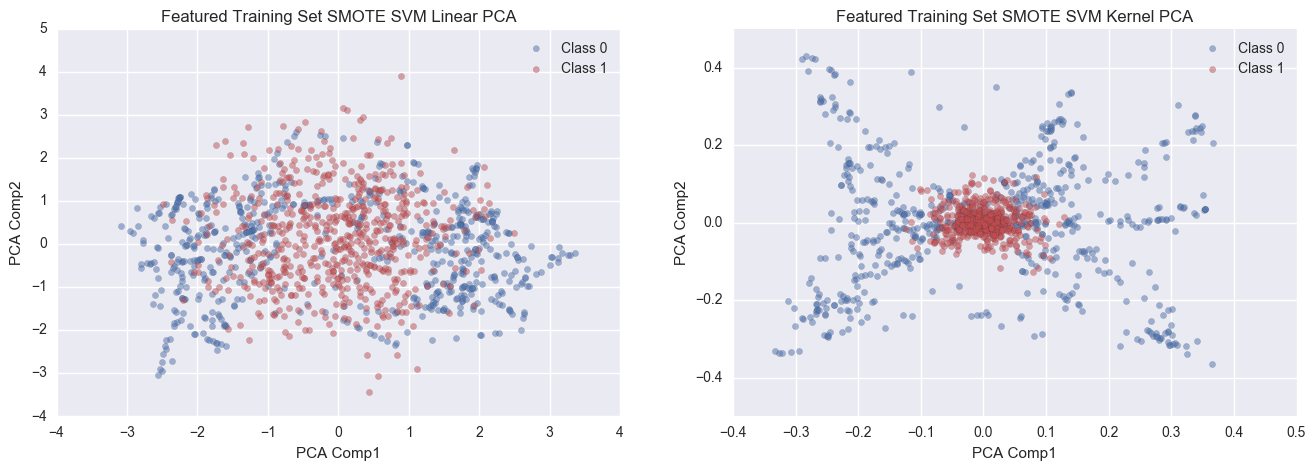

In [17]:
### Plot a 2D space by condensing via PCA/KPCA; alternatively use TSNE
def plot_2d_spaces(X_in, y_in, title_str, axi):
    # ALT: Use TSNE, rather than transforming to another space
    almost_black = '#262626'
    palette = sns.color_palette()
    axi.scatter(X_in[y_in == 0, 0], X_in[y_in == 0, 1], label="Class 0", alpha=0.5,
                edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
    axi.scatter(X_in[y_in == 1, 0], X_in[y_in == 1, 1], label="Class 1", alpha=0.5,
                edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
    axi.set_xlabel("PCA Comp1")
    axi.set_ylabel("PCA Comp2")
    axi.set_title(title_str)
    axi.legend(loc='best')
    
def plot_pca_spaces(X_in, y_in):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    # linear pca
    lin_pca = PCA(n_components=2)
    X_tr_pca = lin_pca.fit_transform(X_in) 
    plot_2d_spaces(X_tr_pca,  y_in, "Featured Training Set SMOTE SVM Linear PCA", ax1)
    # non-linear kernel pca
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.15)
    X_tr_kpca = kpca.fit_transform(X_in)
    plot_2d_spaces(X_tr_kpca, y_in, "Featured Training Set SMOTE SVM Kernel PCA", ax2)

    
plot_pca_spaces(X_train_tr_res, y_train_tr_res)

## Feature Evaluation
- Perform initial feature evaluation selection: we want to to get an idea of the windows we need to search on during cross-validation.  As we don't want to bias our feature selection, we would rather not perform feature selection first, but rather as part of the cross-validation phase.  
- Intial Feature Importance Evaluation Methods
  - PCA per number of components (Requires Standardization of Features)
  - Compare PCA (Linear) w/Kernel PCA (Non-Linear), as our data seems to be quite nonlinear
  - RFE (Wrapper Based) using default hyperparams of models
  - Embedded Model based Feature Importances(IG), Regularization 

PCA First component:	0.114828144116  
PCA Second component:	0.0725799082354 
KPCA First component:	0.0597854034306  
KPCA Second component:	0.0495148553093 


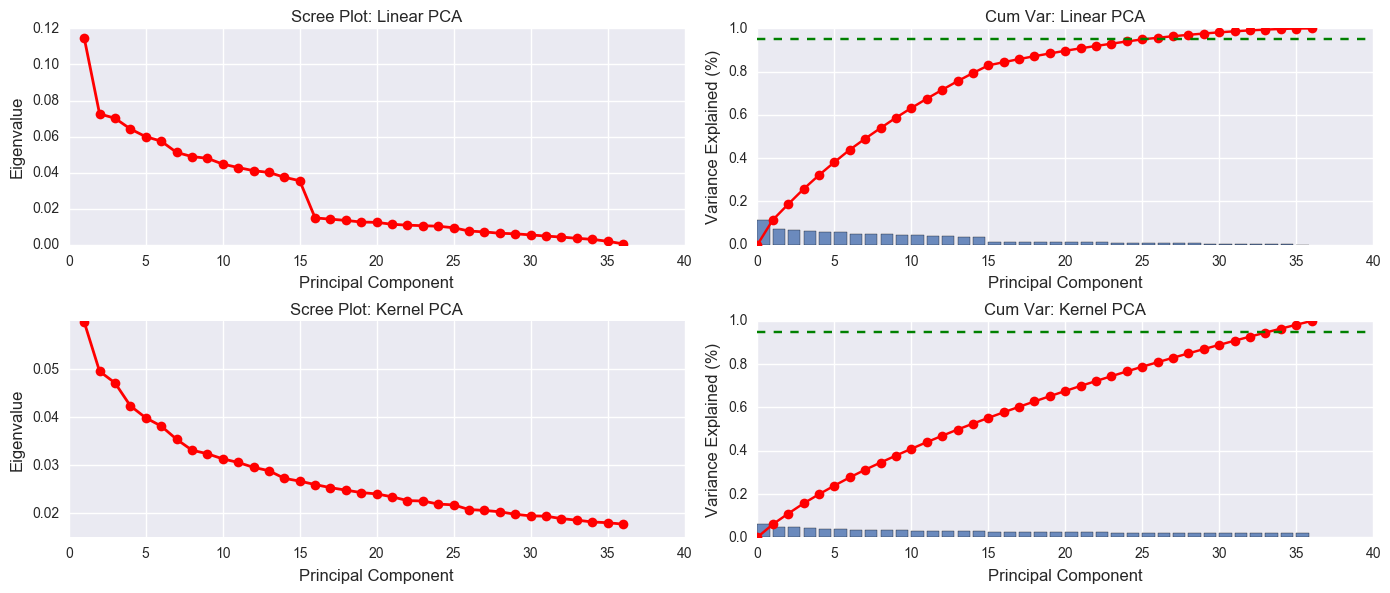

In [18]:
# perform some initial feature evaluation before model fitting
def execute_PCA(X_in, n_comp):
    pca_model = PCA(n_components=n_comp)
    X_tr_pca = pca_model.fit_transform(X_in)
    print "PCA First component:\t{0}  ".format( str(pca_model.explained_variance_ratio_[0]) )
    print "PCA Second component:\t{0} ".format( str(pca_model.explained_variance_ratio_[1]) )
    return pca_model, X_tr_pca, pca_model.explained_variance_ratio_

def execute_KPCA(X_in, n_comp):
    kpca = KernelPCA(n_components=X_in.shape[1], kernel='rbf', gamma=0.15)
    X_tr_kpca = kpca.fit_transform(X_in)
    explained_variance = np.var(X_tr_kpca, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    print "KPCA First component:\t{0}  ".format( str(explained_variance_ratio[0]) )
    print "KPCA Second component:\t{0} ".format( str(explained_variance_ratio[1]) )
    return kpca, X_tr_kpca, explained_variance_ratio

def scree_plot(pca_model, ratios_in, axi, est_name):
    # ALT: Visualization per clusters: MDS/TSNE
    # minimum plot
    ax1, ax2 = axi
    ratios = ratios_in
    ax1.plot(range(1,len(ratios)+1), ratios, 'ro-', linewidth=2)
    ax1.set_xlabel("Principal Component", fontsize=12)
    ax1.set_ylabel("Eigenvalue", fontsize=12)
    ax1.set_title("Scree Plot: {0}".format(est_name))
    # cumulative variance
    cum_var = np.cumsum(ratios)
    ax2.plot(range(len(ratios) + 1), np.insert(cum_var, 0, 0), color = 'r', marker = 'o')
    ax2.bar(range(len(ratios)), ratios, alpha = 0.8)
    ax2.axhline(0.95, color = 'g', linestyle = "--")
    ax2.set_xlabel("Principal Component", fontsize=12)
    ax2.set_ylabel("Variance Explained (%)", fontsize=12)
    ax2.set_title("Cum Var: {0}".format(est_name))
    # common title
    # plt.suptitle("PCA vs KPCA", fontsize=16)
    plt.tight_layout()

fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(14,6))
# Based on the Resampling: There is slight elbow here (16 components), and the 95% cumulative variance (25 Components)
pca_est,  X_tr_pca,  ratios_pca  = execute_PCA(X_train_tr_res,  X_train_tr_res.shape[1])
kpca_est, X_tr_kpca, ratios_kpca = execute_KPCA(X_train_tr_res, X_train_tr_res.shape[1])
scree_plot(pca_est,  ratios_pca,  (ax1[0],ax1[1]), "Linear PCA")
scree_plot(kpca_est, ratios_kpca, (ax2[0],ax2[1]), "Kernel PCA")

         Current function value: 0.608598
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
estimator: logit, #signifigant predictors: 16
Logit Signifiant Predictors:
['proprietary_08', 'proprietary_09', 'proprietary_07', 'proprietary_14', 'proprietary_04', 'clmissed_1', 'clmissed_3', 'prof_1', 'prof_3', 'prof_5', 'prof_8', 'proprietary_10', 'proprietary_17', 'proprietary_18', 'proprietary_20', 'proprietary_22']


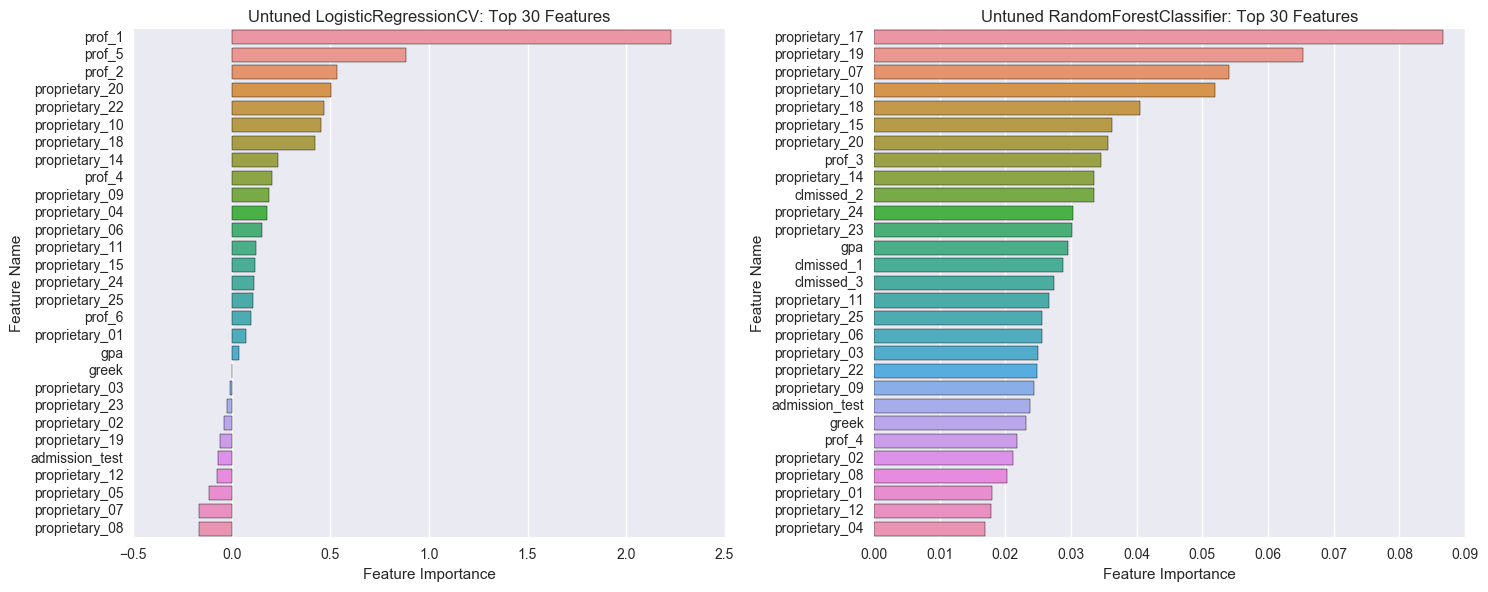

In [19]:
### Embedded Based Methods (via default hyperparam models)
# How many features are really relevant to make a difference to the model
# Notice that a Linear vs Non-Linear model produces different features selected
def logit_signifigant_predictors(X_in, y_in):
    X_const = sm.add_constant(X_in, prepend=True)
    logit_m = sm.Logit(y_in, X_const)
    result  = logit_m.fit(method='bfgs', warn_convergence=False, display=False)
    sig_predictors = result.pvalues[result.pvalues < 0.05].index.tolist()
    print 'estimator: {0}, #signifigant predictors: {1}'.format('logit', (result.pvalues < 0.05).sum())
    return sig_predictors

def clf_lr_importances(estimator_in, X_in, y_in):
    # via regularization if applied
    est = estimator_in
    est.fit(X_in, y_in)
    importances = pd.Series(est.coef_.ravel(), index = X_in.columns).sort_values()
    return (est.__class__.__name__, importances)
    
def clf_tree_importances(estimator_in, X_in, y_in):
    # via impurity in trees and random subselection
    est = estimator_in
    est.fit(X_in, y_in)
    importances = pd.Series(est.feature_importances_, index=X_in.columns).sort_values()
    return (est.__class__.__name__, importances)
    
def plot_feature_importances(est_name, data, axi, k=10):
    data = data[:-k:-1]
    sns.barplot(x=data, y=list(data.index), ax=axi, orient='h')
    axi.set_ylabel("Feature Name")
    axi.set_xlabel("Feature Importance")
    axi.set_title("Untuned {0}: Top {1} Features".format(est_name, k))

# logistic regression case
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
predictors = logit_signifigant_predictors(X_train_tr_res, y_train_tr_res)
estimator  = LogisticRegressionCV(cv=10, scoring='roc_auc')
name, coefs = clf_lr_importances(estimator, X_train_tr_res, y_train_tr_res)
plot_feature_importances(name, coefs, ax1, k=30)
print "Logit Signifiant Predictors:\n{0}".format(predictors)
# random forest case
estimator = RandomForestClassifier()
name, importances = clf_tree_importances(estimator, X_train_tr_res, y_train_tr_res)
plot_feature_importances(name, importances, ax2, k=30)
plt.tight_layout()

In [20]:
### Wrapper Based (Exhausitive, Greedy) Approach: RFE based on a default model; how many Parameters are selected
def eval_rfe_cv(estimator_in, X_in, y_in):
    name = estimator_in.__class__.__name__
    skf  = cv.StratifiedKFold(y_in, n_folds=10, shuffle=True)
    est_rfe = fsel.RFECV(estimator_in, step=1, scoring='roc_auc', cv=skf)
    est_rfe.fit(X_in, y_in)
    k = est_rfe.n_features_
    rankings = sorted(zip(map(lambda x: round(x, 4), est_rfe.ranking_), X_in.columns))
    print "estimator:{0}, k features:{1}, k ranks: {2}\n".format(name, k, map(lambda x: x[1], rankings[:k]))
    
eval_rfe_cv(LogisticRegression(), X_train_tr_res, y_train_tr_res)
eval_rfe_cv(RandomForestClassifier(), X_train_tr_res, y_train_tr_res)
eval_rfe_cv(XGBClassifier(), X_train_tr_res, y_train_tr_res)

estimator:LogisticRegression, k features:27, k ranks: ['clmissed_1', 'clmissed_2', 'clmissed_3', 'prof_1', 'prof_2', 'prof_3', 'prof_4', 'prof_5', 'prof_7', 'prof_8', 'proprietary_01', 'proprietary_04', 'proprietary_05', 'proprietary_06', 'proprietary_07', 'proprietary_08', 'proprietary_09', 'proprietary_10', 'proprietary_11', 'proprietary_14', 'proprietary_15', 'proprietary_17', 'proprietary_18', 'proprietary_20', 'proprietary_22', 'proprietary_24', 'proprietary_25']

estimator:RandomForestClassifier, k features:17, k ranks: ['clmissed_1', 'clmissed_3', 'gpa', 'greek', 'proprietary_01', 'proprietary_02', 'proprietary_07', 'proprietary_08', 'proprietary_09', 'proprietary_11', 'proprietary_14', 'proprietary_15', 'proprietary_17', 'proprietary_19', 'proprietary_20', 'proprietary_22', 'proprietary_25']

estimator:XGBClassifier, k features:33, k ranks: ['admission_test', 'clmissed_1', 'clmissed_3', 'gpa', 'greek', 'prof_1', 'prof_2', 'prof_3', 'prof_5', 'prof_6', 'prof_8', 'proprietary_01'

In [21]:
### Statistical Based Methods
# Note our feature matrix is negative, so we can not use non-negative scoring: e.g. chi-squared
# Anova Based F-Statistic
k_sel=16
kbest = fsel.SelectKBest(k=k_sel)
X_tr = kbest.fit_transform(X_train_tr_res, y_train_tr_res)
kbest_cols = X_train_tr_res.columns[kbest.get_support()].tolist()
print "SelectKBest k={0} columns:\n{1}\n".format(k_sel, kbest_cols)
# Mutual Dependency w/Target
mi = zip(X_train_tr_res.columns.tolist(), fsel.mutual_info_classif(X_train_tr_res, y_train_tr_res))
mitop_cols = [el[0] for el in sorted(mi, key=lambda tup: tup[1], reverse=True) if el[1] > 0.10]
print "Mutual Dependence k={0} columns:\n{1}\n".format(len(mitop_cols), mitop_cols)
# delta
print "Diff: {0}".format(list(set(kbest_cols) - set(mitop_cols)))

SelectKBest k=16 columns:
['admission_test', 'proprietary_11', 'proprietary_07', 'proprietary_14', 'proprietary_25', 'clmissed_1', 'clmissed_2', 'clmissed_3', 'prof_1', 'prof_3', 'prof_5', 'prof_8', 'proprietary_10', 'proprietary_17', 'proprietary_20', 'proprietary_22']

Mutual Dependence k=15 columns:
['admission_test', 'proprietary_15', 'proprietary_20', 'proprietary_22', 'proprietary_10', 'proprietary_18', 'proprietary_06', 'proprietary_24', 'clmissed_1', 'greek', 'proprietary_17', 'proprietary_05', 'proprietary_19', 'clmissed_3', 'clmissed_2']

Diff: ['prof_5', 'prof_8', 'proprietary_11', 'proprietary_07', 'prof_3', 'proprietary_14', 'proprietary_25', 'prof_1']


## Model Selection
- Model Selection via Cross Validation of Scoring Metric
  - Rather than *accuracy* (due to initial imbalance), prefer *roc/auc* or *f1-score*
  - Grid Search via Pipeline and selection of features within stratified cross validation to avoid bias
- Linear Models:
  - Logistic Regression: Binary Class Predictor, Producing Probabilities observation belongs to class
- Non-linearity Supported Models
  - SVM
  - Random Forest Classifier
  - Meta-Algorithm: XGBoost
- High Dimensionality
  - Regularization: per Feature Selection/Reduction (as applies to models)
  - Feature Importance reduction per Random Forest 
  - Kernel PCA performed much better than Linear PCA

In [22]:
params_lr_clf= [{
     'C':  [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],       # Inverse of Regularization Strength
     'penalty': ['l1', 'l2'],
     'class_weight': ['balanced', {1:10}]                      # Multiplied by 'sample_weight'
}]   
params_svc_clf = [
     {'C':  [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],      # Inverse of Regularization Strength  
      'class_weight': ['balanced', {1:10}],                    # Multiplied by 'sample_weight'
      'kernel': ['linear', 'sigmoid']},
     {'C':  [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],      # Inverse of Regularization Strength  
      'class_weight': ['balanced', {1:10}],                    # Multiplied by 'sample_weight'
      'kernel': ['rbf'],                                       # rbf can overfit on wide data
      'gamma':  [1, 0.1, 0.05, 0.01, 0.001, 0.0001]},
     {'C':  [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],      # Inverse of Regularization Strength  
      'class_weight': ['balanced', {1:10}],                    # Multiplied by 'sample_weight'
      'kernel': ['poly'],
      'degree': [0,1,2,3,4]}    
]
params_rf_clf = [{
    'n_estimators': [150],                                     #[10,25,50,75,100,150],
    'criterion':    ['gini'],                                  #['gini', 'entropy'],
    'max_depth':    [6,8,None],                                #[2,4,6,8,10,None],
    'max_features': ['sqrt'],                                  #['auto', 'sqrt', 'log2', None],
    'min_samples_split': [8],                                  #[2,4,6,8,10],
    'min_samples_leaf':  [2],                                  #[1,2,4,6,8,10],
    'min_weight_fraction_leaf': [0.1],                         #[0.1,0.2,0.3,0.4,0.5],
    'max_leaf_nodes': [30,35],                                 #[20,30,40],
    'class_weight':   ['balanced_subsample']                   #['balanced', 'balanced_subsample']    
}]
params_xgb_clf = [{
     'n_estimators': [250,500],                                #[250,500,600,750],
     'max_depth': [6],                                         #[6,8,10],
     'min_child_weight': [1.0],
     'colsample_bytree': [0.5],                                #[0.3,0.4,0.5],
     'subsample': [0.8],                                       #[0.8,1.0],
     'gamma': [0.0],
     'learning_rate': [0.05,0.1],                              #[0.005, 0.05, 0.01, 0.1],                
     'max_delta_step': [1.0],
     'reg_alpha': [0.005],                                     #[0.005, 0.001, 0.05, 0.01, 0.1, 1.0]
     'scale_pos_weight': [1.0],                                #[0.8,0.9,1.0]
}]
### Best parameters
params_lr_best_clf = [{
    'C': [1000.0], 
    'penalty': ['l1'], 
    'class_weight': ['balanced']
}]
params_svc_best_clf = [{
    'gamma':  [10.0], 
    'kernel': ['rbf'], 
    'C': [10.0], 
    'class_weight': ['balanced']
}]
params_rf_best_clf = [{
    'n_estimators': [150],                                     
    'criterion':    ['gini'],                                  
    'max_depth':    [6],                                        # not returned via GS, but we don't want deep trees                 
    'max_features': ['sqrt'],                                  
    'min_samples_split': [8],                                  
    'min_samples_leaf':  [2],                                  
    'min_weight_fraction_leaf': [0.1],                         
    'max_leaf_nodes': [30],                                 
    'class_weight':   ['balanced_subsample'],
    'oob_score': [True]
}]
params_xgb_best_clf = [{
     'n_estimators': [500],                                
     'max_depth': [6],                                         
     'min_child_weight': [1.0],
     'colsample_bytree': [0.5],                                
     'subsample': [0.8],                                       
     'gamma': [0.0],
     'learning_rate': [0.1],                                                   
     'max_delta_step': [1.0],
     'reg_alpha': [0.005],                                     
     'scale_pos_weight': [1.0],                                
}]

In [23]:
def base_estimator_feature_selection(X_in, y_in):
    # Find Optimal Parameters for Base Estimator of Feature Selector
    est  = RandomForestClassifier(oob_score=True, n_jobs=-1)
    param_grid = {
        'n_estimators': [100],                #[10,25,50,75,100,150,200],
        'criterion':    ['gini'],             #['gini', 'entropy'],
        'max_depth':    [None],               #[2,4,6,8,10,None],
        'max_features': ['sqrt'],             #['auto', 'sqrt', 'log2', None],
        'min_samples_split': [4],             #[1,2,4,10],
        'min_samples_leaf':  [1],             #[1,2,4,10],
        'min_weight_fraction_leaf':[0.1],     #[0.1,0.2,0.3,0.4,0.5],
        'max_leaf_nodes': [18],               #[2,4,6,10,12,14,16,18,20,22,24],
        'class_weight':   ['balanced']        #['balanced', 'balanced_subsample']    
    }
    skf  = cv.StratifiedKFold(y_in, n_folds=10, shuffle=True)
    gs_cv = GridSearchCV(estimator=est, param_grid=param_grid, scoring='roc_auc', cv=skf, verbose=True, n_jobs=-1)
    gs_cv.fit(X_in, y_in)
    return gs_cv.best_estimator_

In [24]:
def grid_search_cv(estimator_in, est_grid_in, X_in, y_in):
    # ALT: RandomizedSearchCV (sampling wo/replacement) vs GridSearch(fixed number of param settings)
    name = estimator_in.__class__.__name__
    base_estimator = base_estimator_feature_selection(X_in, y_in)
    pipe = Pipeline([
        ('feat', fsel.SelectFromModel(base_estimator)),
        ('kpca', KernelPCA()),
        ('clf',  estimator_in)
    ])
    params_feat = {'feat__threshold': [0.02,0.04]}              #[0.02, 0.04, 0.06, 0.08]
    params_kpca = {'kpca__n_components':[15,25,30,35],          #[15,25,30,35],          
                   'kpca__kernel': ['rbf'],                     #['linear', 'rbf']
                   'kpca__gamma':  [1.0]}                       #[0.01,0.1,1.0,10.0,100.0]}                    
           
    params = params_kpca
    params.update(params_feat)
    param_grid = [{'clf' + '__' + k:v for k,v in d.iteritems()} for d in est_grid_in]
    for d in param_grid: d.update(params)
    
    # avoid hang issue with n_jobs=-1, set n_jobs=1 for now
    skf  = cv.StratifiedKFold(y_in, n_folds=5, shuffle=True)
    gs_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='roc_auc', 
                         cv=skf, verbose=True, n_jobs=1)
    gs_cv.fit(X_in, y_in)
    # print gs_cv.best_estimator_, gs_cv.best_params_, gs_cv.grid_scores
    return (gs_cv, name, gs_cv.best_score_)

# As grid search takes a long time, manually perform iterations, rather than programatically within a loop
# Resulting Scores : {ROC/AUC Scores: Logistic: ~0.95, SVC(rbf kernel): ~0.98, Random Forest: ~0.96, XGB: ~0.97}
estimators = [LogisticRegression(), XGBClassifier(), svm.SVC(), RandomForestClassifier()]
est_select = RandomForestClassifier()
gs_cv, est_name, est_score = grid_search_cv(est_select, params_rf_best_clf, X_train_tr_res, y_train_tr_res)
print "Estimator: {0}, Score: {1}".format(est_name, est_score)
# Transform data according to optimal pipeline, serialize pipeline to disk for use
# Note not all estimators support the transform, so we would need to handle the pipeline differently
X_train_pipeline = gs_cv.transform(X_train_tr_res)
X_test_pipeline  = gs_cv.transform(X_test_tr)
print "Transformed Feature Space Dimensions: {0}".format(X_train_pipeline.shape[1])

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.3min finished


Estimator: RandomForestClassifier, Score: 0.974200050391
Transformed Feature Space Dimensions: 10


## Final Model Evaluation
- Per final selected model
    - ROC/AUC Curves
    - Learning Curves
    - Other Calculated Metrics: e.g. F1-Score, Precision, Recall, Accuracy 

In [25]:
def fit_estimator(estimator_in, params_in, X_in, y_in):
    extracted_dict = {k: v[0] for k,v in params_in[0].iteritems() }
    sel_estimator = estimator_in(**extracted_dict)
    sel_estimator.fit(X_in, y_in)
    return sel_estimator

sel_estimator = fit_estimator(RandomForestClassifier, params_rf_best_clf, X_train_pipeline, y_train_tr_res)

In [26]:
# Find the Optimal threshold for binary classification 
def determine_optimal_threshold(X_in, y_in, estimator_in):
    # determine the best threshold, instead of the 50% Split 
    # this assumes we are using the positive label as 1
    yhat_probas = estimator_in.predict_proba(X_in)
    fpr, tpr, thresholds = metrics.roc_curve(y_in, yhat_probas[:, 1])
    idx = np.arange(len(tpr)) 
    df_roc = pd.DataFrame({'fpr'    : pd.Series(fpr, index=idx),
                           'tpr'    : pd.Series(tpr, index = idx), 
                           '1-fpr'  : pd.Series(1-fpr, index = idx), 
                           'tf'     : pd.Series(tpr - (1-fpr), index = idx), 
                           'thresh' : pd.Series(thresholds, index = idx)})

    optimal_slice = df_roc.ix[(df_roc.tf-0).abs().argsort()[:1]]
    print "Optimal Decision Boundary:\n{0}".format(optimal_slice)
    return list(optimal_slice.thresh)[0]

# Calculate Metrics
def calculate_metrics(y_test_in, yhat_in):
    calc_metrics = {
        "roc_auc":    metrics.roc_auc_score(y_test_in, yhat_in),
        "precision":  metrics.precision_score(y_test_in, yhat_in),
        "recall":     metrics.recall_score(y_test_in, yhat_in),
        "f1":         metrics.f1_score(y_test_in, yhat_in),
        "accuracy":   metrics.accuracy_score(y_test_in, yhat_in)
    }

    #print metrics.classification_report(y_test_in, yhat_in)
    #sklearn confusion matrix returns [[tn,fp], [fn, tp]]; 
    [[tn,fp],[fn,tp]] = metrics.confusion_matrix(y_test_in, yhat_in)
    cm = pd.DataFrame( np.array([[tp,fn],[fp,tn]]), index=[1,0], columns=[1,0] )
    cm.index.name = 'actual'
    return calc_metrics, cm

# Calculate Metrics based on a new threshold, this should be done on the Training Data
opt_thresh  = determine_optimal_threshold(X_train_pipeline, y_train_tr_res, sel_estimator)
# Make new predictions and metric calculations on training results
yhat_probas = sel_estimator.predict_proba(X_test_pipeline)
yhat_thresh = map(lambda x: 1 if x > opt_thresh else 0, yhat_probas[:,1])
yhat_baseline = sel_estimator.predict(X_test_pipeline)
baseline_metrics, cm_baseline = calculate_metrics(y_test, yhat_baseline)
newthreshold_metrics, cm_threshold = calculate_metrics(y_test, yhat_thresh)
display( pd.DataFrame([baseline_metrics, newthreshold_metrics], index=['baseline', 'thresholded']) )
print "Confusion Matrix Format: {0}".format("[[tp,fn], [fp,tn]]")
print "Confusion Matrix Baseline:"; display(cm_baseline)
print "Confusion Matrix Modified Threshold:"; display(cm_threshold)

Optimal Decision Boundary:
       1-fpr       fpr   tf   thresh       tpr
71  0.922222  0.077778  0.0  0.40057  0.922222


,accuracy,f1,precision,recall,roc_auc
baseline,0.850000,0.916512,0.918216,0.914815,0.590741
thresholded,0.886667,0.938406,0.918440,0.959259,0.596296


Confusion Matrix Format: [[tp,fn], [fp,tn]]
Confusion Matrix Baseline:


,1,0
actual,,
1,247,23
0,22,8


Confusion Matrix Modified Threshold:


,1,0
actual,,
1,259,11
0,23,7


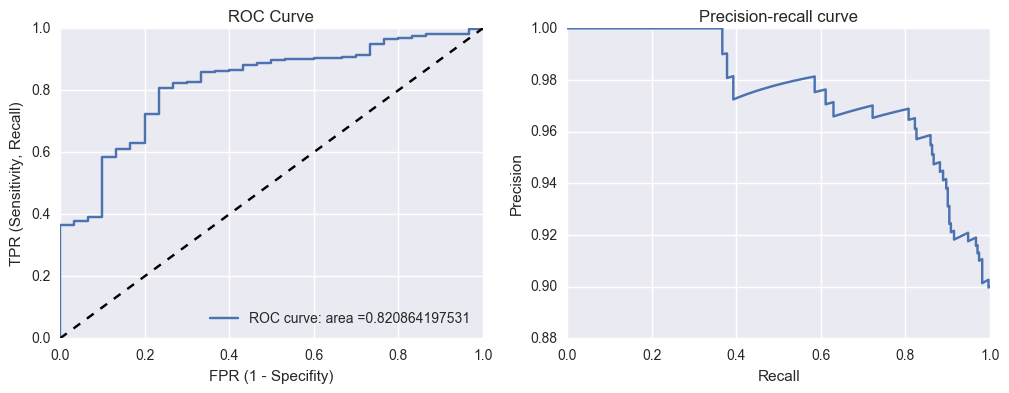

In [27]:
def plot_roc_curve(estimator_in, X_test_in, y_test_in, axi):
    # TBD: plot as a function of K-folds
    # auc is more meaningful than accuracy per imbalanced classes; ranking of positive classes
    yhat_probas = estimator_in.predict_proba(X_test_in)
    fpr, tpr, thresholds = metrics.roc_curve(y_test_in, yhat_probas[:, 1], pos_label=1)
    threshholds_compute = np.sort(yhat_probas[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    # plot probabilitiy estimates
    axi.plot(fpr, tpr, label='ROC curve: area ={0}'.format(roc_auc))
    axi.plot([0, 1], [0, 1], 'k--')  
    axi.set_xlim([0.0, 1.0])
    axi.set_ylim([0.0, 1.0])
    axi.set_xlabel('FPR (1 - Specifity)')
    axi.set_ylabel('TPR (Sensitivity, Recall)')
    axi.set_title('ROC Curve')
    axi.legend(loc="lower right")

def plot_pr_curve(estimator_in, X_test_in, y_test_in, axi):
    yhat_probas = estimator_in.predict_proba(X_test_in)
    pr, rec, thresholds = metrics.precision_recall_curve(y_test_in, yhat_probas[:, 1], pos_label=1)
    threshholds_compute = np.sort(yhat_probas[:,1])
    # plot probability estimates
    axi.plot(rec, pr)
    axi.set_xlabel('Recall')
    axi.set_ylabel('Precision')
    axi.set_title('Precision-recall curve')
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))  
# TBD: Plot Baseline and Plot Modified TPR/FPR based on new thresholds
# goal: want to determine which students in danger of falling behind; minimize number of FN when non-graduated=Pos
plot_roc_curve(sel_estimator, X_test_pipeline,  y_test, ax1)
plot_pr_curve(sel_estimator,  X_test_pipeline,  y_test, ax2)

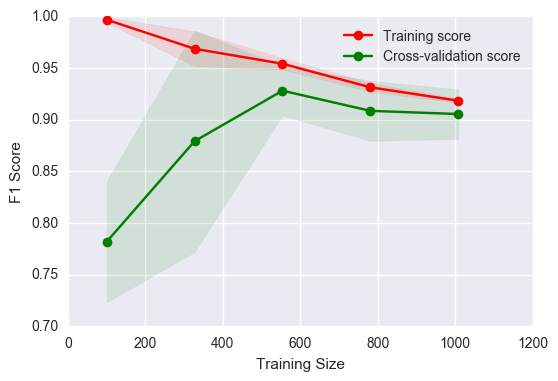

In [28]:
# Evaluate Learning Curves
def plot_learning_curve(estimator_in, X_in, y_in):
    scores = list()
    train_sizes=np.linspace(.1, 1.0, 5)
    train_sizes, train_scores, test_scores = \
    learning_curve(estimator_in, X_in, y_in, scoring='f1', cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",  label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',  color="g",  label="Cross-validation score")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    
plot_learning_curve(sel_estimator, X_train_pipeline, y_train_tr_res)

## Summary
- Goal
    - As we want to help those students that are in danger of *not-graduating*, we would like to minimize *FN*, per Positive case considered as 'Graduating', implying low FN, High Recall, while still predicting a high TP.
- Due to the high imbalance in graduates vs non-graduates, different imbalanced methods were applied:
    - Resample the Training data: SMOTE or SMOTE-SVC
    - Adjust Weights per model loss function proportional to class frequencies ('balanced')
    - Determine the effect of modifying the decision threshold (in contrast to 0.5 boundary) in an ROC/AUC Curve, as the ROC Curve is insensitive to predicted probabilities properly calibrated.  As we lowered the threshold (e.g. 0.4), we were able to reduce the number of FN, without effecting the number of FP for the most part, while overall improving a high TPR.
    - Evaluation was performed via *roc-auc* rather than *accuracy* as a metric (alternatively F1 Score)
- Non-Linearity Relationships
    - As the dataset reflected a non-linear relationship:
        - Model Selection was given to those that perform well with non-linear relationships
        - Dimensionality Reduction was performed via a Kernel PCA, in contrast to PCA (Linear)
- Feature Selection/Extraction Reduction 
    - Initial Cleaning was performed that did not add much value: (variance threshold, redundant correlations)
    - Embedded Methods: via Selecting feature importances from a Model (RandomForest) based on a threshold
    - Exploring how the different features compare in order to subset the space to GridSearch over
    - Feature Selection could be further improved via further nested-cross validation for selection
- PreProcessing Methods
    - Outlier Detection
    - Categorical Data/One Hot Encoding
    - Imputation based on Missing Values
    - Identification of possible New Features
    - Standardization to place features on equal footing
    - Initial Feature Selection
    - Resampling on Training Set
- Model Evaluation
    - The models are performing relatively the same(0.95+ ROC/AUC on Training), however this is most likely due to the preprocessing feature engineering, feature selection (per Random Forest) and applying non-linear transformations (e.g. KPCA instead of PCA).  The AUC was much lower when evaluated with Linear PCA, on the order of ~0.20 (0.70+) difference.  Further regularization can be applied to avoid overfitting on the training set if needed.
    - In this case, we would probably favor a resulting simpler model than a complex model, so we could have just as likely selected Logistic Regression, assuming the previous steps are in place.
- Overfit Evaluation
    - Based on the Learning Curves, it does not look like we have overfit the model, as the gap is small as the number of training examples increases.  If the gap was large, its **possible more data** could have helped.